In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../../')
from radmc.setup import radmc3d_setup
from radmc.simulate import generate_simulation
from radmc.plot import generate_plot

from radmc3dPy.image import *
from radmc3dPy.analyze import *
from radmc3dPy.data import *

Fast (Fortran90) Mie-scattering module could not be imported. Falling back to the slower Python version.


In [2]:
class general_parameters:
    '''
    A class to store the parameters for individual kinds of grids.
    Details of individual parameters should refer to the functions that generate the grids.
    '''
    def __init__(self, **kwargs
                 ):
        for k, v in kwargs.items():
          # add parameters as attributes of this object
          setattr(self, k, v)

    def __del__(self):
      pass

    def add_attributes(self, **kwargs):
      '''
      Use this function to set the values of the attributs n1, n2, n3,
      which are number of pixels in the first, second, and third axes. 
      '''
      for k, v in kwargs.items():
        # add parameters as attributes of this object
        setattr(self, k, v)

In [3]:
model = radmc3d_setup(silent=False)
model.get_mastercontrol(filename=None,
                        comment=None,
                        incl_dust=1,
                        incl_lines=1,
                        nphot=100000,
                        nphot_scat=500000,
                        scattering_mode_max=2,
                        istar_sphere=1,
                        num_cpu=None)
model.get_linecontrol(filename=None,
                      methanol='ch3oh leiden 0 0 0')
model.get_continuumlambda(filename=None,
                          comment=None,
                          lambda_micron=None,
                          append=False)

model.get_diskcontrol(  d_to_g_ratio = 0.01,
                        a_max=0.1, 
                        Mass_of_star=0.14, 
                        Accretion_rate=5e-7,
                        Radius_of_disk=50,
                        NR=200,
                        NTheta=200,
                        NPhi=10)
model.get_vfieldcontrol(Kep=True,
                        vinfall=0.5,
                        Rcb=None,
                        outflow=None)
model.get_heatcontrol(heat='accretion')
model.get_gasdensitycontrol(abundance=1e-10,
                            snowline=100,
                            enhancement=1e5,
                            gas_inside_rcb=True)

You have 12 Processors
get_continuumlambda: No input wavelength.
get_continuumlambda: Re-creating wavelength_micron.inp using default wavelengths.


In [5]:
condition_parms = general_parameters(
    nodust      = False,
    scat        = True,
    extract_gas = True,
)

simulate_mutual_parms = {
    "incl"      : 70,
    "line"      : 240,
    "npix"      : 500,
    "sizeau"    : 300,
    "posang"    : 45,
    "v_width"   : 10,
    "vkms"      : 0,
    "v_width"   : 10,
    "dir"       : './test/',
    "fname"     : 'test',
}

channel_cube_parms = general_parameters(
    **simulate_mutual_parms,
    nlam=11,
)

pv_cube_parms = general_parameters(
    **simulate_mutual_parms,
    nlam=50,
)

sed_parms = general_parameters(
    **simulate_mutual_parms, 
    scat=True,
    freq_min=5e1, freq_max=5e2, nlam=10,
)

spectrum_parms = general_parameters(
    **simulate_mutual_parms,
    nlam=10
)
conti_parms = general_parameters(
    **simulate_mutual_parms,
    wav=1300,
    scat=True,
)

simulation_parms = general_parameters(
    condition_parms    = condition_parms,
    channel_cube_parms = channel_cube_parms,
    pv_cube_parms      = pv_cube_parms,
    conti_parms        = conti_parms,
    sed_parms          = sed_parms,
    spectrum_parms     = spectrum_parms,
    save_out=True,
    save_npz=True,
)

simulation = generate_simulation(
    parms=simulation_parms,
    channel       = False,
    pv            = False,
    conti         = True,
    sed           = False,
    line_spectrum = False
)

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2023 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, follow the   
                     RADMC-3D code on github                     
             https://github.com/dullemond/radmc3d-2.0            
                                                                 
       

In [40]:
cube = readImage('./test/outfile/channel_test_scat.out')
convolved_cube = cube.imConv(dpc=140, fwhm=[0.68, 0.58], pa=90)
# convolved_cube = cube
conti = readImage('./test/outfile/channel_test_conti.out')
convolved_conti = conti.imConv(dpc=140, fwhm=[0.68, 0.58], pa=90)
# convolved_conti = conti
convolved_conti_image = np.tile(convolved_conti.imageJyppix, (1, 1, convolved_cube.imageJyppix.shape[2]))
convolved_conti.imageJyppix = convolved_conti_image
convolved_cube.imageJyppix = convolved_cube.imageJyppix - convolved_conti.imageJyppix


Reading ./test/outfile/channel_test_scat.out
Reading ./test/outfile/channel_test_conti.out


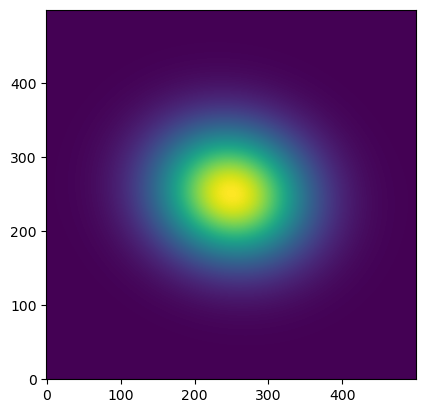

In [69]:
moment1 = convolved_cube.getMomentMap(moment=0, wav0=1372.43349)
# convolved_cube.plotMomentMap(moment=0, wav0=1372.43349, arcsec=True, dpc=140)
plt.imshow(moment1.T, origin='lower')
plt.show()

Reading ./test/outfile/conti_test_scat.out
5.797220008905405e-14


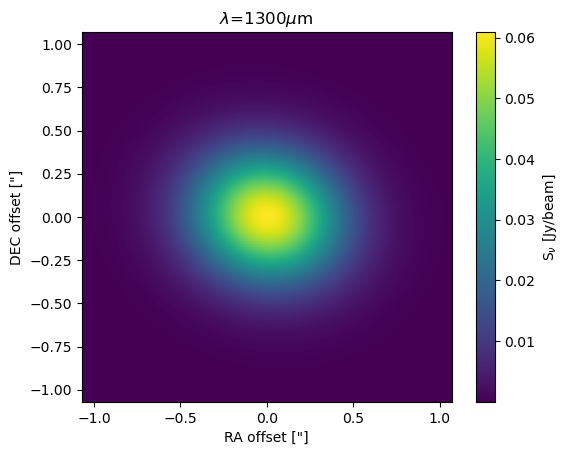

3.6840805914695265


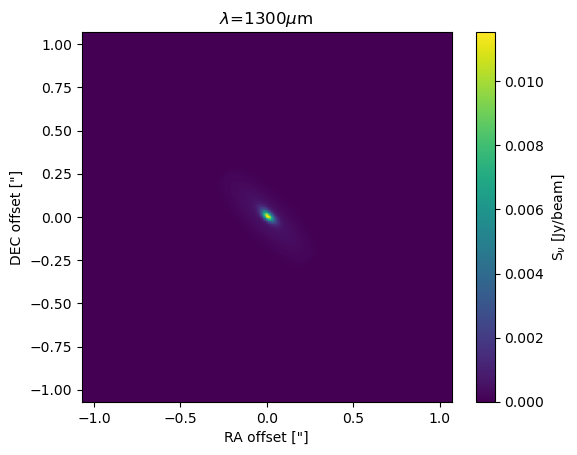

{'implot': <matplotlib.image.AxesImage at 0x32e8d1010>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x137acea20>}

In [78]:
continuum = readImage('./test/outfile/conti_test_scat.out')
convolved_continuum = continuum.imConv(dpc=140, fwhm=[0.68, 0.58], pa=90)
plotImage(image=convolved_continuum, arcsec=True, dpc=140, bunit='jy/beam', cmap='viridis')

convolved_continuum = continuum.imConv(dpc=140, fwhm=[0.0363, 0.0274], pa=-69.4)
plotImage(image=convolved_continuum, arcsec=True, dpc=140, bunit='jy/beam', cmap='viridis')
